# Using a Merton model to calculate probability of default and equity value for any public company in 10 years
Note: This is the simplest use of the model for learning purposes

In [172]:
##importing all the libraries
import numpy as np
import pandas as pd
from scipy.stats import norm
import yfinance as yf
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

# Merton equation:
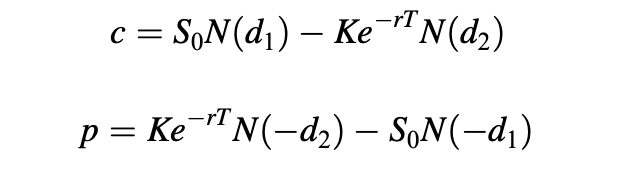
**where,**
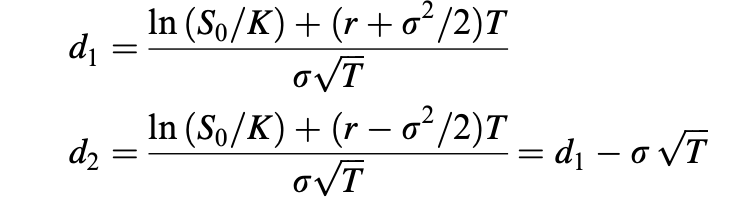


In [175]:
def merton_model(A,D,r,vol,T):
    """
    Calculates the equity value and probabilty of default using the Merton model.
    """
    d1 = (np.log(A/D) + (r +(vol ** 2)/2)*T)/(vol*np.sqrt(T))
    d2 = d1 - vol * np.sqrt(T)
    E = A * norm.cdf(d1) - D * np.exp(-r * T) * norm.cdf(d2)
    p = norm.cdf(-d2)
    
    return E, p

In [148]:
##Get company's ticker and confirm if it's valid using yfinance
def validate_ticker(ticker):
    try:
        company_data = yf.Ticker(ticker).info
        if company_data:  # Check if data exists
            print("Ticker is valid.")
            return True  # Indicate valid ticker
        else:
            print(f"Ticker '{ticker}' is not valid.")
            return False  # Indicate invalid ticker

    except Exception as e:
        print(f"Error checking ticker: {e}. Ticker '{ticker}' is likely invalid.")
        return False  # Indicate invalid ticker

# Example Usage:
ticker = input("Enter ticker: ").strip().upper()
if validate_ticker(ticker):
    print("Proceeding with ticker.")
else:
    print("Ticker validation failed.")

Enter ticker:  rddt


Ticker is valid.
Proceeding with ticker.


Getting company's Asset Value (A) and Debt (D) from Yahoo Finance, using latest available data

In [158]:
## Get company's asset value and debt 
company = yf.Ticker(ticker)
##print (company.balance_sheet)
latest_date = company.balance_sheet.columns[0]
print (latest_date)

#Getting total liability and asset value
total_debt = company.balance_sheet.loc['Total Debt'].iloc[0]
total_assets = company.balance_sheet.loc['Total Assets'].iloc[0]

print(f"Total Debt: {total_debt}")
print(f"Total Assets: {total_assets}")

2024-12-31 00:00:00
Total Debt: 26702000.0
Total Assets: 2336595000.0


Since we are looking at 10 yr time horizon, defining time (T) as 10 yrs and defining risk free rate (r) as 10 yrs treasury note yield - imported from Federal Reserve Economic Data API

In [177]:
#Say we want get default risk for 10 yrs time horizon
time= 10
#Using FRED API to get 10 year treasury note yield
try:
    data = pdr.DataReader('DGS10', 'fred', start= latest_date, end= latest_date)
    print(data) ##prints the data frame
    risk_free_rate = data['DGS10'].iloc[-1] / 100 #convert to decimal
    print(f"10 year treasury rate for {latest_date}: {risk_free_rate}")

except Exception as e:
    print(f"Error retrieving data: {e}")

            DGS10
DATE             
2024-12-31   4.58
10 year treasury rate for 2024-12-31 00:00:00: 0.0458


Asset volatility was the toughest to estimate. For simplicity I took the deviation of the percentage total asset return as the volatility (vol)

In [179]:
##checking and removing any null values
print (company.balance_sheet.loc['Total Assets'])
assets_data = company.balance_sheet.loc['Total Assets'].dropna()
print (assets_data)

2024-12-31    2336595000.0
2023-12-31    1596467000.0
2022-12-31    1599711000.0
2021-12-31    1645109000.0
2020-12-31             NaN
Name: Total Assets, dtype: object
2024-12-31    2336595000.0
2023-12-31    1596467000.0
2022-12-31    1599711000.0
2021-12-31    1645109000.0
Name: Total Assets, dtype: object


In [181]:
def estimate_asset_volatility(assets_data,annualization_factor =1):
    asset_values = assets_data.values # Get the values as a NumPy array
    print("Asset Values:", asset_values)
    """
    Estimates asset volatility using percentage returns.
    """
    percentage_returns = (asset_values[1:] - asset_values[:-1]) / asset_values[:-1]
    asset_volatility = np.std(percentage_returns) * np.sqrt(annualization_factor)
    return asset_volatility  

vol = estimate_asset_volatility(assets_data)
print (f"Asset Volatility is: {vol}")

Asset Values: [2336595000.0 1596467000.0 1599711000.0 1645109000.0]
Asset Volatility is: 0.15685683815482343


In [185]:
equity_value, probability_of_default = merton_model(total_assets,total_debt,risk_free_rate,vol,time)
print (f"Estimated Equity value: {equity_value}")
print (f"Estiamted Probablity of default: {probability_of_default}")

Estimated Equity value: 2319704717.290311
Estiamted Probablity of default: 1.6557597877337656e-22
